# Analyzing and Visualizing River Discharge Data Across Multiple Watersheds

**Author:** [Javed Ali](https://www.javedali.net/) (University of Central Florida)  
**Date:** July 15, 2023

## Overview

This Jupyter notebook is dedicated to the analysis and visualization of river discharge data spanning multiple catchments in NYC area. The data for each catchment is stored separately in CSV files located in distinct directories. Each file contains discharge data for a specific storm event, with the discharge values indexed by time. 

The primary aim of this notebook is to aggregate the separate data sets into a unified pandas DataFrame. Following the unification of data, the script computes the average, minimum, and maximum discharge values across all watersheds. 

The processed data is then visualized using `matplotlib`, with the creation of a line plot. This plot illustrates the change in river discharge over time for each watershed, whilst also overlaying the overall average, minimum, and maximum discharges for comparative analysis. Each watershed's data is represented in light grey, while the average, minimum, and maximum discharges are highlighted with black, red, and blue lines respectively.

## Outputs

1. **Merged Data CSV:** The notebook consolidates the river discharge data from multiple watersheds into a single CSV file. This merged file contains the discharge data of all catchments for a specific storm event. The filename follows the format `{directory}_merged_data.csv`, where `directory` is the name of the storm event. Each row in the file represents a unique timestamp, and each column (excluding the 'time' column) represents a unique catchment. The cells in the file contain the river discharge values at the corresponding timestamps for the respective catchments.

2. **Visual Plot:** The notebook generates a detailed line plot visualizing the river discharge data over time. The plot includes an overlay of the overall average, minimum, and maximum discharges, facilitating comparative analysis across all watersheds. The plot is saved as a PNG file with a filename pattern of `{watershed_ID}_discharge_{storm_name}.png`.

Both the merged CSV file and the PNG plot include comprehensive labels and legends, aiding in the interpretation and understanding of the data.

## Notebook Execution

1. **Import Required Libraries:** All necessary libraries, such as pandas and matplotlib, are imported.

2. **Read Catchment Areas:** The catchment areas are read from a CSV file. These areas are used later to convert the discharge data from m/hr to m³/s.

3. **Merge and Plot Discharge Data:** The notebook processes and merges all CSV files from a list of directories into a single DataFrame. This DataFrame is then used to generate a plot of the river discharge data.

The analysis and visualization tasks are primarily performed by the `process_and_plot_files` function. This function takes a directory and a list of IDs as inputs, processes the data from the corresponding directories, merges them into a single DataFrame, and generates the plot.

## Data and Methods

This notebook processes data from multiple CSV files, each containing river discharge data for a specific storm event. The data for each storm is organized by time, facilitating the analysis of discharge patterns over the duration of the storm.

The method followed involves reading the individual CSV files, merging them into a single DataFrame, calculating the average, minimum, and maximum discharge values, and then creating a plot to visualize these values.

The discharge data in the original files is given in m/hr. This is converted to m³/s using the catchment area data, with the conversion formula as follows:

$$
Discharge (m^3/s) = Discharge (m/hr) \times Area (sqkm) \times \frac{1000000}{3600}
$$

## Visualization

The visualization is a detailed line plot, displaying the river discharge values over time for each watershed. The overall average, minimum, and maximum discharges are also plotted for comparison. The plot includes annotations for the catchment ID and the average, minimum, and maximum values. The figure is saved as a PNG file for further use.

## Conclusion

This notebook provides a comprehensive approach to aggregating and analyzing river discharge data from multiple watersheds. The generated plot offers a clear view of the discharge values over time, aiding in the study of storm impact across different areas. Moreover, the creation of a merged CSV file allows for a consolidated view of the data and facilitates further analysis or reuse of the data.



---


## Import the required libraries

In [1]:
# If watermark library is not installed
!pip install watermark -q

In [2]:
# !pip install adjustText -q

In [2]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
# from adjustText import adjust_text

import pandas as pd
import os
import re

from tqdm.notebook import tqdm

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%reload_ext watermark

In [3]:
%watermark

Last updated: 2023-07-20T15:49:35.896463+00:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.107+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 14
Architecture: 64bit



---

In [4]:
# check the current directory
os.getcwd()

'/home/jovyan/data/ngen-cfe-hydrological-model/notebooks/ngen'

## Read the file that contain catchment areas

We will use it for the conversion of the discharge data from $m/hr$ to $m^3/s$ by using the catchment area data. The formula for the conversion is:

$Discharge (m^3/s) = Discharge (m/hr) * Area (sqkm) * 1000000 / 3600$


In [5]:
catchment_areas_df = pd.read_csv("catchments_areas_final.csv")

In [6]:
catchment_areas_df

,Catchment ID,Watershed ID,Area (sqkm)
0,cat-694856,wb-694856,34.734145
1,cat-694725,wb-694725,89.274602
2,cat-694855,wb-694855,8.872208
3,cat-694724,wb-694724,9.534596
4,cat-694854,wb-694854,32.326199
5,cat-694723,wb-694723,12.438456
6,cat-694722,wb-694722,9.945451
7,cat-694852,wb-694856,34.757993
8,cat-694853,wb-694856,8.031149
9,cat-698886,wb-698891,4.483801


## Merge all catchments for each storm and plot the discharge data

In [7]:
# Defining a helper function to extract the catchment ID from a filename
def get_catchment_id(filename):
    """
    Extracts catchment ID from the given filename.

    Args:
        filename : str : Name of the file.

    Returns:
        str : Catchment ID prefixed by 'cat-', suffixed by '-discharge', or None if no match.
    """
    # Regular expression search to find the catchment ID in the filename
    match = re.search(r'nex-(\d+)_output.csv', filename)
    
    # If a match is found, prefix 'cat-', suffix '-discharge' and return. If no match, return None.
    return 'cat-' + match.group(1) + '-discharge' if match else None


# Defining the main function to process and plot data
def process_and_plot_files(directory, ids_list):
    """
    Process and Merges all CSV files from a list of directories into one DataFrame and plot the data.

    Args:
        directory : str : The directory where the watershed directories are stored.
        ids_list : list : List of directories to process, named 'wb-{catchment_ID}'.

    Returns:
        None
    """
    # Initialize an empty DataFrame to store all data
    all_data = pd.DataFrame()

    # Initialize a set to store catchment IDs that have been processed
    processed_catchments = set()
    
    # Iterating over each watershed ID in the provided list
    for wb_id in ids_list:
        # Constructing the path to the directory for the current watershed
        full_directory = os.path.join(directory, wb_id, 'outputs')

        # Creating a list of all CSV files in the directory that match our naming pattern
        csv_files = [f for f in os.listdir(full_directory) if f.endswith('.csv') and f.startswith('nex')]
        
        # Iterating over each CSV file in the directory
        for file in csv_files:
            
            # Extract the catchment ID from the file name
            catchment_id = get_catchment_id(file)
            
            # If the catchment ID has already been processed, skip it
            if catchment_id in processed_catchments:
                continue
            
            # If the catchment ID in the filename matches the current watershed ID or is one of the additional catchments, process it
            if catchment_id.replace('cat-', '').replace('-discharge', '') in [wb_id.replace('wb-', ''), '694852', '694853', '698886']:
                file_path = os.path.join(full_directory, file)
                
                # Add the catchment ID to the set of processed catchments
                processed_catchments.add(catchment_id)
                
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path, header=None, names=['index', 'time', catchment_id])
                
                # Drop the 'index' column from the DataFrame
                df = df.drop(columns=['index'])
                
                # Convert the 'time' column to datetime format
                df['time'] = pd.to_datetime(df['time'])
                
                # If we are processing 'catch-694723-discharge', duplicate it as 'catch-694722-discharge' before converting to m3/s
                if catchment_id == 'cat-694723-discharge':
                    df['cat-694722-discharge'] = df[catchment_id]

                # Convert discharge to m3/s
                area_sqkm = catchment_areas_df.loc[catchment_areas_df["Catchment ID"] == catchment_id.replace('-discharge', ''), "Area (sqkm)"].values[0]
                df[catchment_id] = df[catchment_id] * area_sqkm * 1000000 / 3600

                # Convert the duplicated 'catch-694722-discharge' to m3/s with different area
                if 'cat-694722-discharge' in df.columns:
                    area_sqkm_694722 = catchment_areas_df.loc[catchment_areas_df["Catchment ID"] == 'cat-694722', "Area (sqkm)"].values[0]
                    df['cat-694722-discharge'] = df['cat-694722-discharge'] * area_sqkm_694722 * 1000000 / 3600
                
                # If all_data is empty, copy df. Otherwise, merge df into all_data on 'time' column.
                all_data = pd.merge(all_data, df, on='time', how='outer') if not all_data.empty else df

    # Save the merged data to a CSV file
    all_data.to_csv(f'{directory}/{directory}_merged_data.csv', index=False)
    
    # Identify the discharge columns
    discharge_cols = [col for col in all_data.columns if 'discharge' in col.lower()]
    
    # Calculate average, minimum, and maximum discharge
    all_data['average'] = all_data[discharge_cols].mean(axis=1)
    all_data['minimum'] = all_data[discharge_cols].min(axis=1)
    all_data['maximum'] = all_data[discharge_cols].max(axis=1)

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 7))

    # Define the colors for the special lines
    special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

    # Plot the average, minimum, and maximum discharges
    for line, color in special_lines.items():
        ax.plot(all_data['time'], all_data[line], label=line, linewidth=2, linestyle='--', color=color)

    # Plot the discharge data for each catchment
    for col in discharge_cols:
        ax.plot(all_data['time'], all_data[col], color='lightgray')

        # Add annotation for the catchment ID
        last_value = all_data[col].iat[-1]
        last_time = all_data['time'].iat[-1]
        ax.annotate(col.replace('-discharge', ''), xy=(last_time, last_value), xycoords='data', color='darkgray', 
                    xytext=(5, -5), textcoords='offset points')

    # Set the title and labels
    ax.set_title(f'River Discharge during the {directory} in NYC', fontsize=18, y=1.03)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(f'River Discharge $(m^3/s)$', fontsize=14)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Increase the size of the x and y ticks labels
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Define offsets for the special lines annotations to prevent overlap
    special_offsets = {'average': (-55, 25), 'minimum': (-55, 15), 'maximum': (-55, 35)}

    # Adding average, minimum, and maximum values to the plot as annotation
    # for line, color in special_lines.items():
    #     value = all_data[line].iat[-1]
    #     pos = all_data['time'].iat[-1]
    #     ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, 
    #                 xytext=special_offsets[line], textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))

    # Set grid properties
    ax.grid(True, linestyle='-', color='0.75', linewidth=0.25)
    
    # Add legend
    ax.legend()

    # Apply tight layout before saving
    plt.tight_layout()

    # Saving the figure with 400dpi
    fig.savefig(f"{directory}/{directory}_discharge.png", dpi=400, bbox_inches='tight')

    # Displaying the plot
    plt.show()

### 1. Tropical Storm Barry

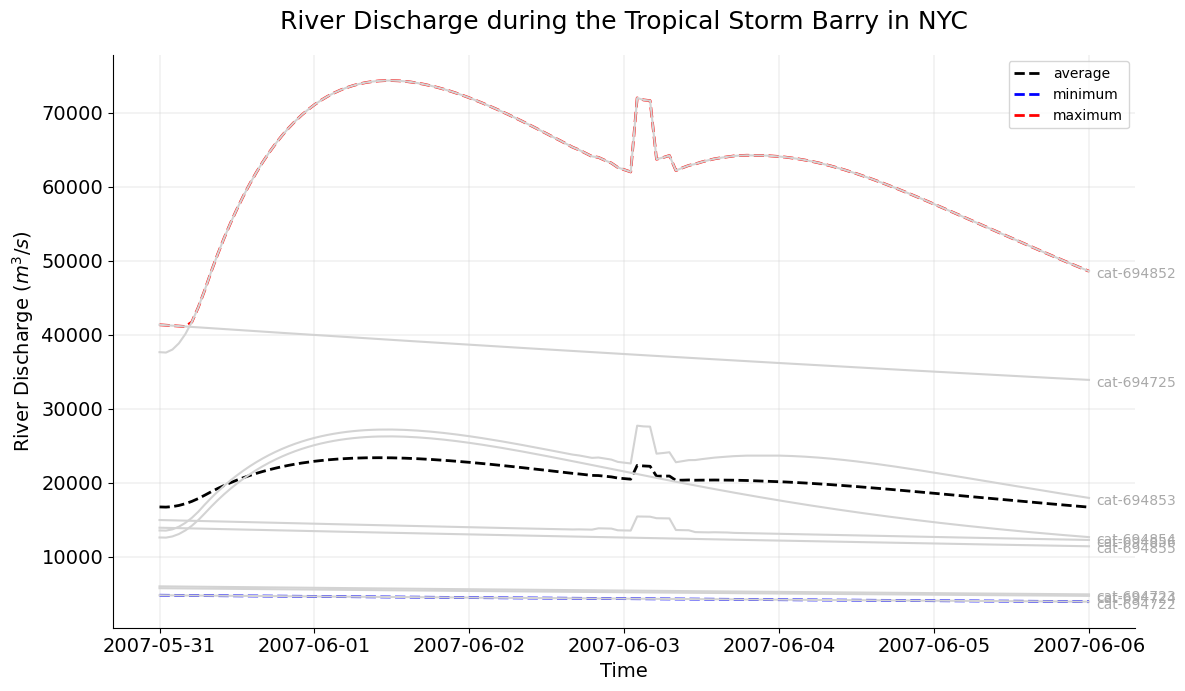

In [8]:
# Specify the storm name
storm_name = 'Tropical Storm Barry'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 2. Hurricane Arthur

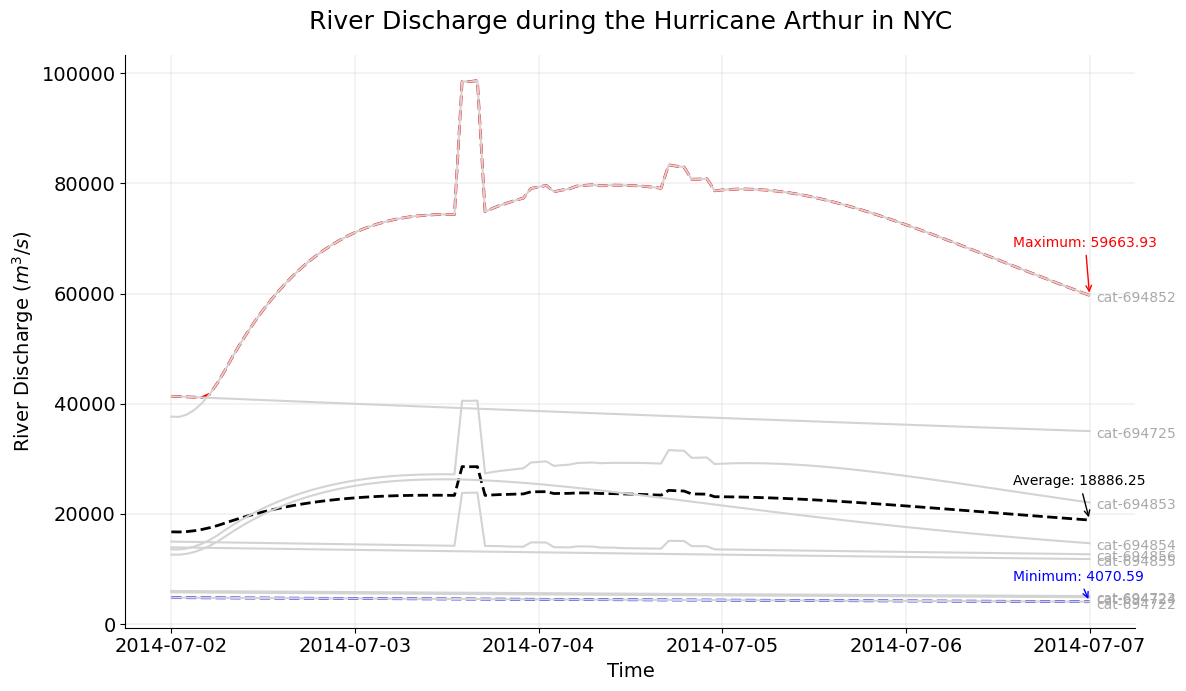

In [12]:
# Specify the storm name
storm_name = 'Hurricane Arthur'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 3. Hurricane Dorian

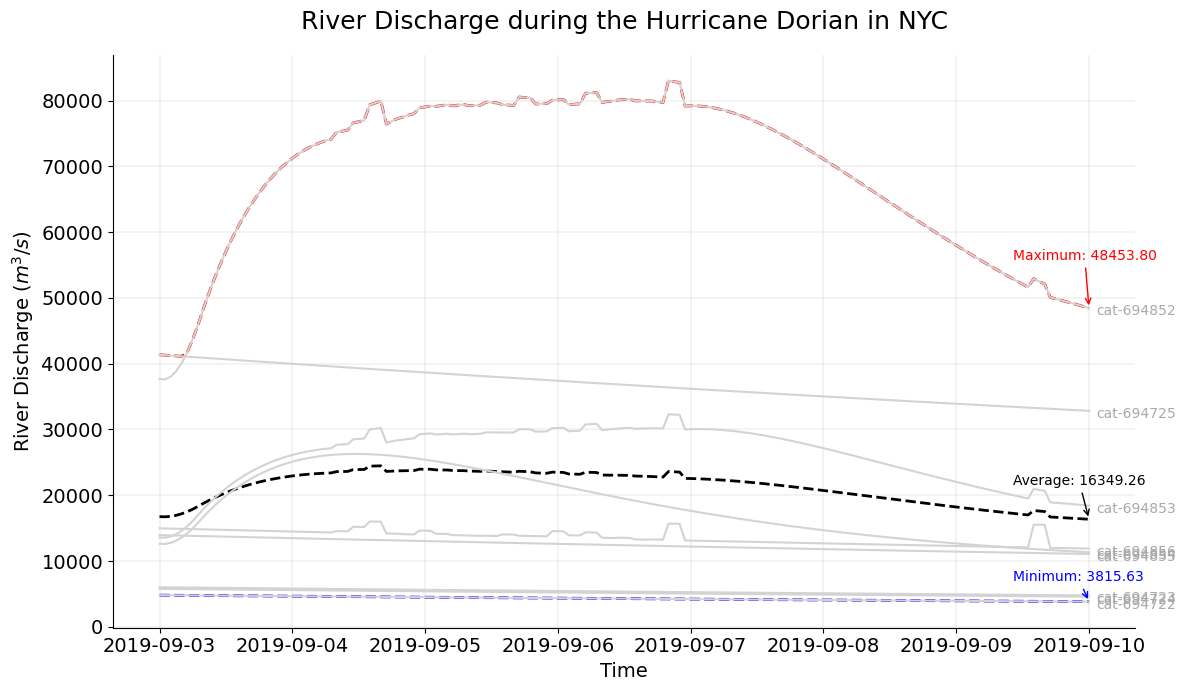

In [13]:
# Specify the storm name
storm_name = 'Hurricane Dorian'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 4. Hurricane Irene

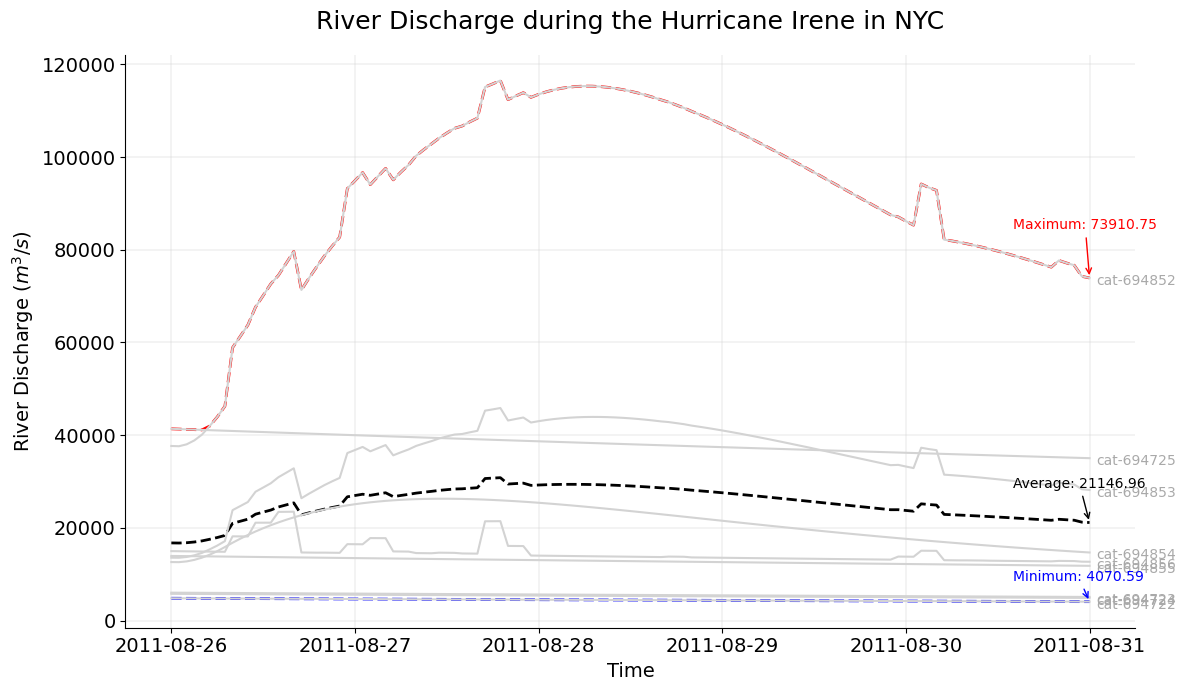

In [14]:
# Specify the storm name
storm_name = 'Hurricane Irene'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 5. Hurricane Hanna

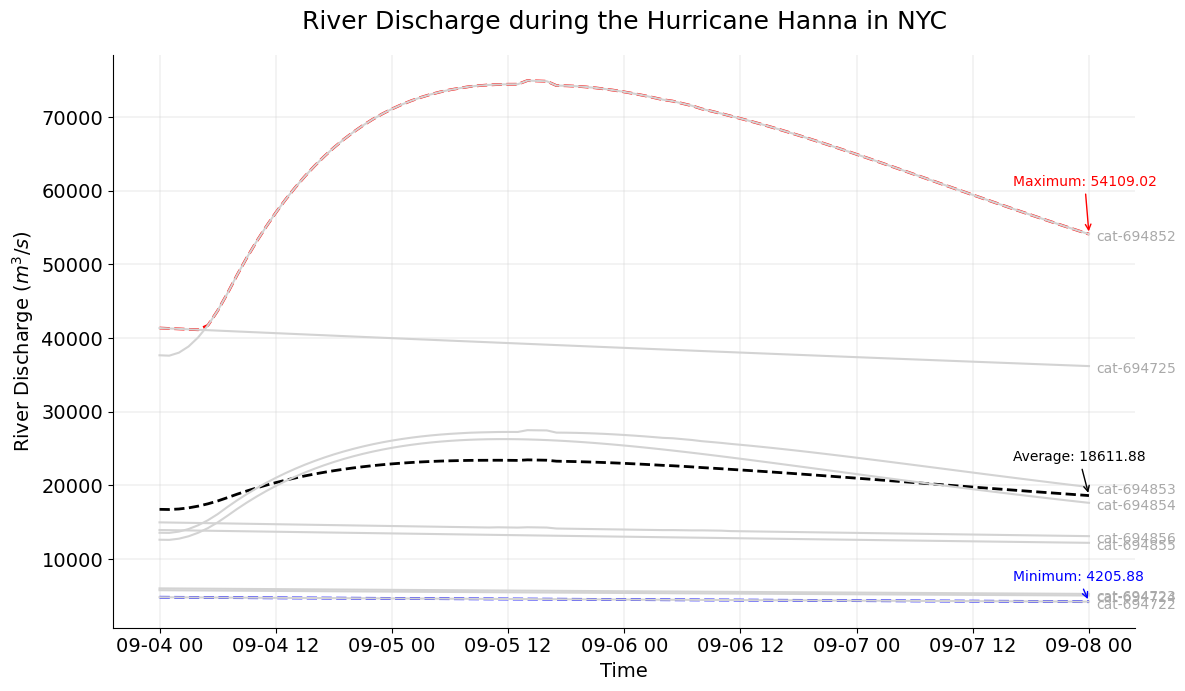

In [15]:
# Specify the storm name
storm_name = 'Hurricane Hanna'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 6. Tropical Storm Phillipe

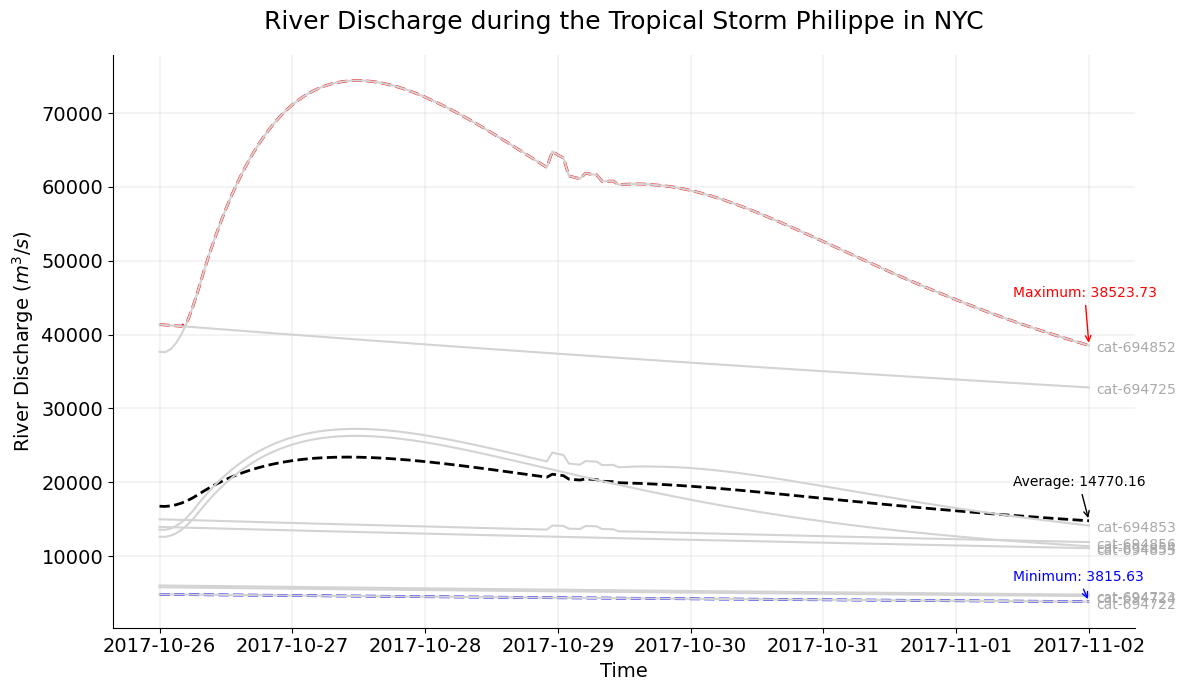

In [16]:
# Specify the storm name
storm_name = 'Tropical Storm Philippe'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 7. Tropical Storm Ogla

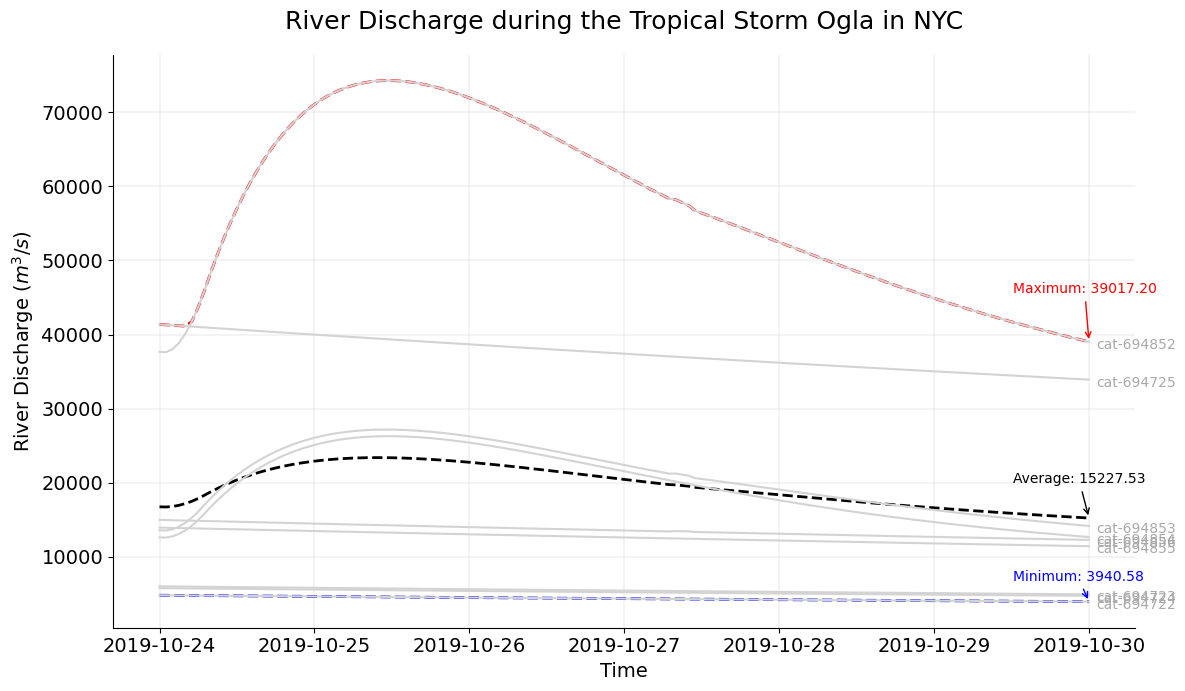

In [17]:
# Specify the storm name
storm_name = 'Tropical Storm Ogla'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 8. Tropical Storm Jose

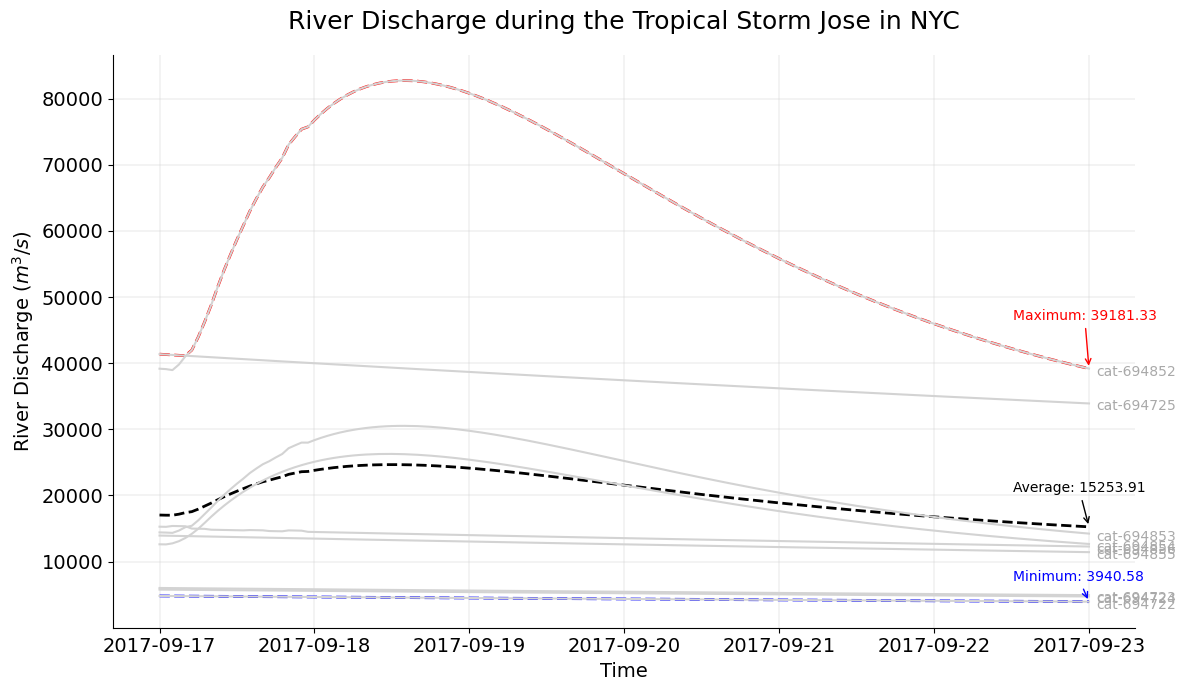

In [18]:
# Specify the storm name
storm_name = 'Tropical Storm Jose'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

### 9. Hurricane Sandy

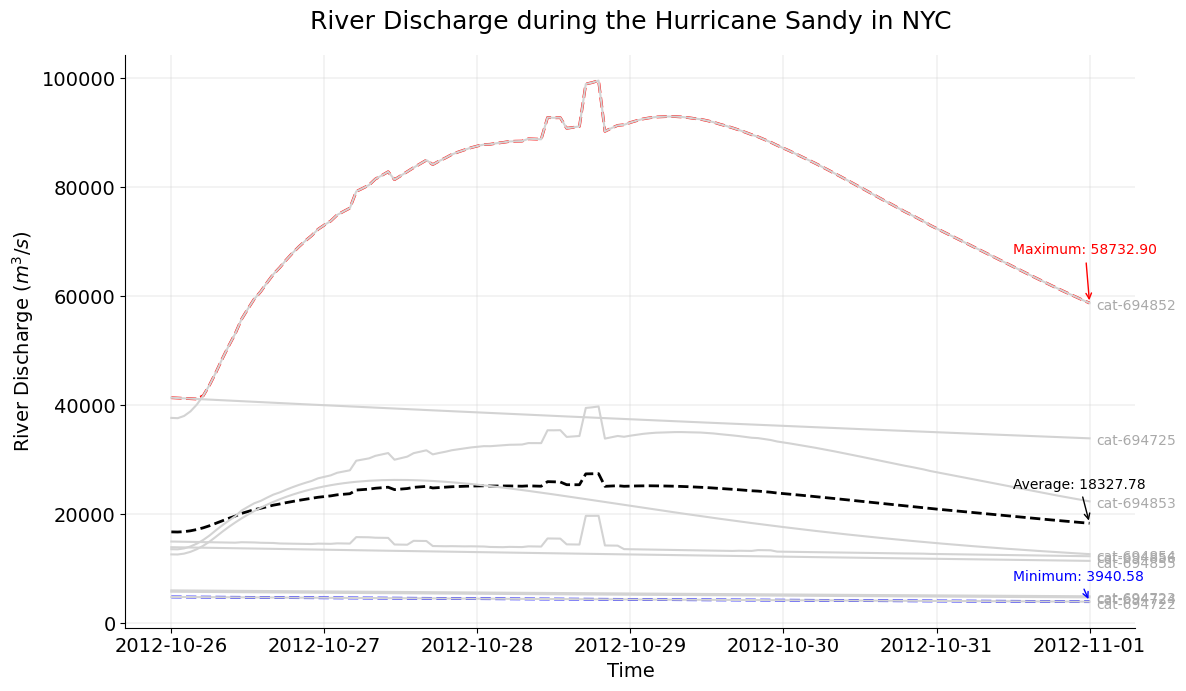

In [19]:
# Specify the storm name
storm_name = 'Hurricane Sandy'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

---

## ROUGH WORK

In [ ]:
# # Defining a helper function to extract the catchment ID from a filename
# def get_catchment_id(filename):
#     """
#     Extracts catchment ID from the given filename.

#     Args:
#         filename : str : Name of the file.

#     Returns:
#         str : Catchment ID prefixed by 'catch-', suffixed by '-discharge', or None if no match.
#     """
#     # Regular expression search to find the catchment ID in the filename
#     match = re.search(r'nex-(\d+)_output.csv', filename)
    
#     # If a match is found, prefix 'catch-', suffix '-discharge' and return. If no match, return None.
#     return 'cat-' + match.group(1) + '-discharge' if match else None


# # Defining the main function to process and plot data
# def process_and_plot_files(directory, ids_list):
#     """
#     Process and Merges all CSV files from a list of directories into one DataFrame and plot the data.

#     Args:
#         directory : str : The directory where the watershed directories are stored.
#         ids_list : list : List of directories to process, named 'wb-{catchment_ID}'.

#     Returns:
#         None
#     """
#     # Initialize an empty DataFrame to store all data
#     all_data = pd.DataFrame()
    
#     # Iterating over each watershed ID in the provided list
#     for wb_id in ids_list:
#         # Constructing the path to the directory for the current watershed
#         full_directory = os.path.join(directory, wb_id, 'outputs')

#         # If the current watershed is 'wb-698891', handle it as a special case
#         if wb_id == 'wb-698891':
#             file_path = os.path.join(full_directory, 'nex-698887_output.csv')
#             # Read the file and continue to the next iteration
#             df = pd.read_csv(file_path, header=None, names=['index', 'time', 'cat-698891-discharge'])
#             df = df.drop(columns=['index'])
#             df['time'] = pd.to_datetime(df['time'])
            
#             # Convert discharge to m3/s
#             area_sqkm_698891 = catchment_areas_df.loc[catchment_areas_df["Catchment ID"] == 'cat-698891', "Area (sqkm)"].values[0]
#             df['cat-698891-discharge'] = df['cat-698891-discharge'] * area_sqkm_698891 * 1000000 / 3600

#             all_data = pd.merge(all_data, df, on='time', how='outer') if not all_data.empty else df
#             continue

#         # Creating a list of all CSV files in the directory that match our naming pattern
#         csv_files = [f for f in os.listdir(full_directory) if f.endswith('.csv') and f.startswith('nex')]
        
#         # Iterating over each CSV file in the directory
#         for file in csv_files:
            
#             # Extract the catchment ID from the file name
#             catchment_id = get_catchment_id(file)
            
#             # If the catchment ID in the filename matches the current watershed ID, process it
#             if catchment_id.replace('cat-', '').replace('-discharge', '') == wb_id.replace('wb-', ''):
#                 file_path = os.path.join(full_directory, file)
                
#                 # Read the CSV file into a DataFrame
#                 df = pd.read_csv(file_path, header=None, names=['index', 'time', catchment_id])
                
#                 # Drop the 'index' column from the DataFrame
#                 df = df.drop(columns=['index'])
                
#                 # Convert the 'time' column to datetime format
#                 df['time'] = pd.to_datetime(df['time'])
                
#                 # If we are processing 'catch-694723-discharge', duplicate it as 'catch-694722-discharge' before converting to m3/s
#                 if catchment_id == 'cat-694723-discharge':
#                     df['cat-694722-discharge'] = df[catchment_id]

#                 # Convert discharge to m3/s
#                 area_sqkm = catchment_areas_df.loc[catchment_areas_df["Catchment ID"] == catchment_id.replace('-discharge', ''), "Area (sqkm)"].values[0]
#                 df[catchment_id] = df[catchment_id] * area_sqkm * 1000000 / 3600

#                 # Convert the duplicated 'catch-694722-discharge' to m3/s with different area
#                 if 'cat-694722-discharge' in df.columns:
#                     area_sqkm_694722 = catchment_areas_df.loc[catchment_areas_df["Catchment ID"] == 'cat-694722', "Area (sqkm)"].values[0]
#                     df['cat-694722-discharge'] = df['cat-694722-discharge'] * area_sqkm_694722 * 1000000 / 3600
                
#                 # If all_data is empty, copy df. Otherwise, merge df into all_data on 'time' column.
#                 all_data = pd.merge(all_data, df, on='time', how='outer') if not all_data.empty else df
#                 break

#     # Save the merged data to a CSV file
#     all_data.to_csv(f'{directory}/{directory}_merged_data.csv', index=False)
    
    
#     # Identify the discharge columns
#     discharge_cols = [col for col in all_data.columns if 'discharge' in col.lower()]
    
#     # Calculate average, minimum, and maximum discharge
#     all_data['average'] = all_data[discharge_cols].mean(axis=1)
#     all_data['minimum'] = all_data[discharge_cols].min(axis=1)
#     all_data['maximum'] = all_data[discharge_cols].max(axis=1)

#     # Plot the data
#     fig, ax = plt.subplots(figsize=(12, 7))

#     # Define the colors for the special lines
#     special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

#     # Plot the average, minimum, and maximum discharges
#     for line, color in special_lines.items():
#         ax.plot(all_data['time'], all_data[line], label=line, linewidth=2, linestyle='--', color=color)

    
#     # Plot the discharge data for each catchment
#     for col in discharge_cols:
#         ax.plot(all_data['time'], all_data[col], color='lightgray')

#         # Add annotation for the catchment ID
#         last_value = all_data[col].iat[-1]
#         last_time = all_data['time'].iat[-1]
#         ax.annotate(col.replace('-discharge', ''), xy=(last_time, last_value), xycoords='data', color='darkgray', 
#                     xytext=(5, -5), textcoords='offset points')

#     # Set the title and labels
#     ax.set_title(f'River Discharge during the {directory} in NYC', fontsize=18, y=1.03)
#     ax.set_xlabel('Time', fontsize=14)
#     ax.set_ylabel(f'River Discharge $(m^3/s)$', fontsize=14)

#     # Remove the right and top spines
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     # Increase the size of the x and y ticks labels
#     ax.tick_params(axis='x', labelsize=14)
#     ax.tick_params(axis='y', labelsize=14)

#     # Define offsets for the special lines annotations to prevent overlap
#     special_offsets = {'average': (-55, 25), 'minimum': (-55, 15), 'maximum': (-55, 35)}

#     # Adding average, minimum, and maximum values to the plot as annotation
#     for line, color in special_lines.items():
#         value = all_data[line].iat[-1]
#         pos = all_data['time'].iat[-1]
#         ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, 
#                     xytext=special_offsets[line], textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))

#     # Set grid properties
#     ax.grid(True, linestyle='-', color='0.75', linewidth=0.25)

    
#     # Customize the legend
#     # handles, labels = ax.get_legend_handles_labels()
#     # h_special = [handles.pop(labels.index(l)) for l in special_lines]
#     # l_special = [labels.pop(labels.index(l)) for l in special_lines]
#     # h_discharge = handles
#     # l_discharge = labels

#     # Create two legends: one for special lines, another for discharge columns
#     # legend_discharge = ax.legend(h_discharge, l_discharge, loc='upper left', bbox_to_anchor=(1.02, 0.4), title='Catchments', ncol=2)
#     # legend_special = ax.legend(h_special, l_special, loc='upper left', bbox_to_anchor=(1.02, 0.8), title='Statistics')
#     # ax.add_artist(legend_discharge)

#     # Apply tight layout before saving
#     plt.tight_layout()

#     # Saving the figure with 400dpi
#     fig.savefig(f"{directory}/{directory}_discharge.png", dpi=400, bbox_inches='tight')

#     # Displaying the plot
#     plt.show()


### Plot the data

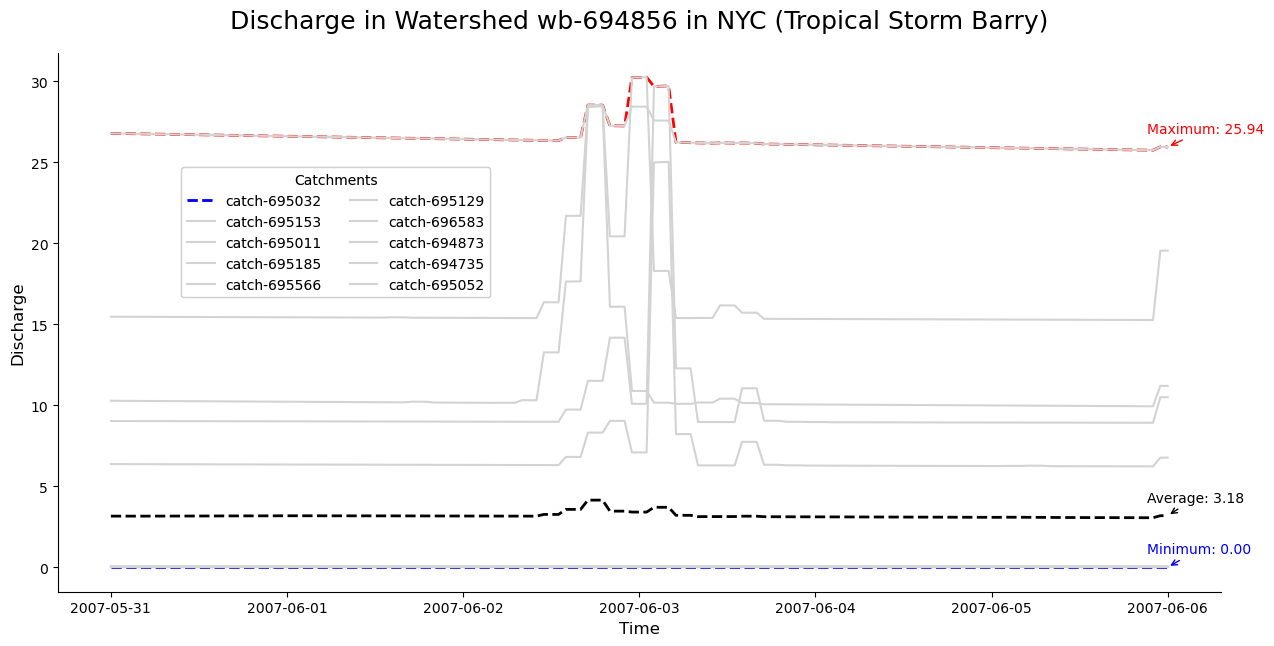

In [48]:
# # Converting the 'time' column to datetime format
# data['time'] = pd.to_datetime(data['time'])

# # Identifying the discharge columns
# discharge_cols = [col for col in data.columns if 'discharge' in col.lower()]

# # Calculating the average, minimum, and maximum of the discharge columns
# data['average'] = data[discharge_cols].mean(axis=1)
# data['minimum'] = data[discharge_cols].min(axis=1)
# data['maximum'] = data[discharge_cols].max(axis=1)

# # Identifying the top 5 columns with the highest and lowest maximum discharge
# max_values = data[discharge_cols].max()
# top_5_highest = max_values.nlargest(5).index.tolist()
# top_5_lowest = max_values.nsmallest(5).index.tolist()
# subset_cols = top_5_highest + top_5_lowest

# # Creating a new figure
# fig, ax = plt.subplots(figsize=(15, 7))

# # Defining the colors for the special lines
# special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

# # Plotting the average, minimum, and maximum discharges
# for line, color in special_lines.items():
#     ax.plot(data['time'], data[line], label=line, linewidth=2, linestyle='--', color=color)

# # Plotting the discharge data for the subset of columns
# for col in subset_cols:
#     ax.plot(data['time'], data[col], label=col.replace('-discharge', ''), color='lightgray')

# # Set the title and labels
# ax.set_title(f'Discharge in Watershed {wb_id} in NYC (Tropical Storm Barry)', fontsize=18, y=1.03)
# ax.set_xlabel('Time', fontsize=12)
# ax.set_ylabel('Discharge', fontsize=12)

# # Removing the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Customizing the legend
# handles, labels = ax.get_legend_handles_labels()
# h_special = [handles.pop(labels.index(l)) for l in special_lines]
# l_special = [labels.pop(labels.index(l)) for l in special_lines]
# h_discharge = handles
# l_discharge = labels

# # Creating two legends: one for special lines, another for discharge columns
# legend_discharge = ax.legend(h_discharge, l_discharge, loc='upper left', bbox_to_anchor=(0.10, 0.8), title='Catchments', ncol=2)
# # legend_special = ax.legend(h_special, l_special, loc='upper left', bbox_to_anchor=(0.70, 0.8), title='Statistics')
# ax.add_artist(legend_discharge)

# # Adding average, minimum, and maximum values to the plot as annotation
# for line, color in special_lines.items():
#     value = data[line].iat[-1]
#     pos = data['time'].iat[-1]
#     ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, xytext=(-15, 10), 
#                 textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))

# # Adjusting the layout
# # fig.subplots_adjust(right=0.8)

# # Save the figure 
# fig.savefig(f"../{wb_id}_discharge_{storm_name}.png", dpi=400, bbox_inches='tight')

# plt.show()